# HW 8 : Forward Filtering

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv("simdata.csv")
vy = df.values[0][1:]
mF = df.values[1:][:, 1:]
T, p = vy.shape[0], mF.shape[0]
vm0 = np.zeros((p, 1))
mC0 = 0.1*np.eye(p)
amG = [np.eye(p)]*T
amW = [0.1 * np.eye(p)]*T
vV = 0.5 * np.ones(T)

In [14]:
# prepare
    
def FF(vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    
    
    vm = vm0
    mC = mC0
    
    # main loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        mm[t, :] = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        amC[t] = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        
    return mm, amC

In [15]:
mm, mC = FF(vy, mF, vV, amG, amW, vm0, mC0)
b1, b2, b3, b4 = mm[:, 0], mm[:, 1], mm[:, 2] ,mm[:, 3]

In [16]:
true = pd.read_csv("truebeta.csv")
beta1 = true.values[0, 1:]
beta2 = true.values[1, 1:]
beta3 = true.values[2, 1:]
beta4 = true.values[3, 1:]

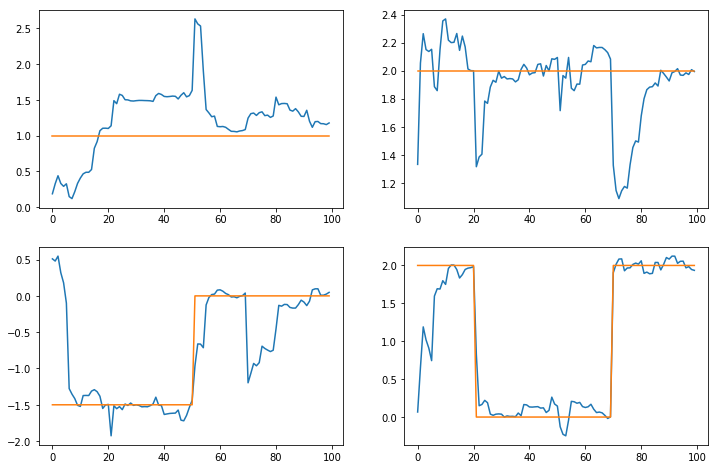

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0,0].plot(beta1)
ax[0, 1].plot(b2)
ax[0, 1].plot(beta2)
ax[1, 0].plot(b3)
ax[1, 0].plot(beta3)
ax[1, 1].plot(b4)
ax[1, 1].plot(beta4)

# HW 9 (Q1 a): Forward Filtering and Backward Sampling 

In [20]:
def FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0):
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    amb = [0]*T
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    if m.ndim == 1:
        mb = np.random.normal(m.astype(np.float64), np.sqrt(C_float), size = nsim)
    else:
        mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
        
    amb[T-1] = mb
    
    for t in reversed(range(T-1)):
        
        if m.ndim == 1:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), 1/amR[t+1].astype(np.float64))
            
        else:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), np.linalg.inv(amR[t+1].astype(np.float64)))
            
        mH = amC[t]- np.dot(np.dot(mB, amR[t+1]), mB.T)
        if m.ndim == 1:
            mean = mm[t, :] + (mb - ma[t+1, :])*mB
            
        else:
            mean = mm[t, :] + np.dot((mb - ma[t+1, :]), mB.T)
            
        H_float = mH.astype(np.float64)
        
        if m.ndim == 1:
            mb = mean.astype(np.float64) + np.random.normal(np.zeros(p), np.sqrt(H_float), size = nsim)
        else:
            mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(p), H_float, size = nsim)
        amb[t] = mb
        
    return amb

In [21]:
nsim  = 5000
amb = FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0)

In [22]:
# aggregate

b1 = np.zeros(T)
b2 = np.zeros(T)
b3 = np.zeros(T)
b4 = np.zeros(T)
beta = [b1, b2, b3, b4]

for t in range(T-1):
    for i in range(p):
        beta[i][t] = np.mean(amb[t][:, i])

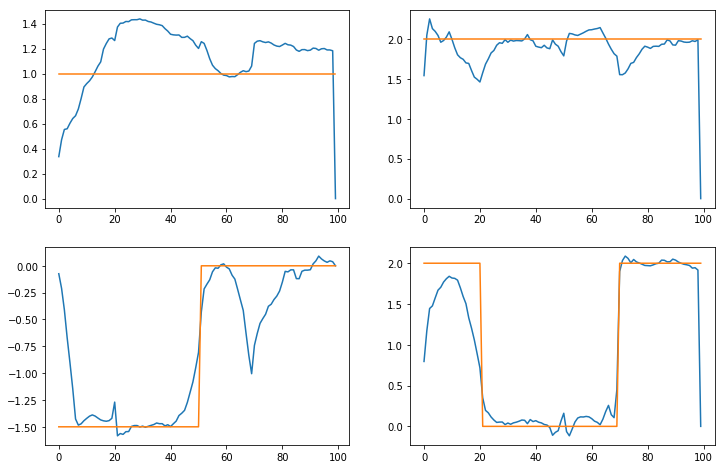

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0,0].plot(beta1)
ax[0, 1].plot(b2)
ax[0, 1].plot(beta2)
ax[1, 0].plot(b3)
ax[1, 0].plot(beta3)
ax[1, 1].plot(b4)
ax[1, 1].plot(beta4)

# HW 9 (Q2 b) : Stochastic Volatity Model

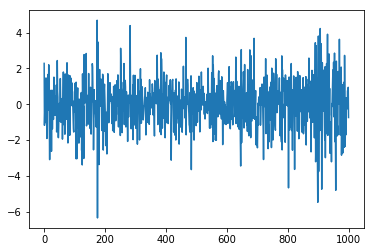

In [24]:
# data
svdata = pd.read_csv("sv_simdata.csv")
vy = svdata.values[0][1:]
plt.plot(vy)

In [25]:
# true parameters
T = vy.shape[0]
vm0 = np.array([0])
mC0 = np.array([0.1])
dmu = np.array([0])
dphi = np.array([0.95])
dsig2 = np.array([0.1])
amG = [dphi]*T
amW = [dsig2]*T

In [26]:
# approximation
vy = np.array([np.log(i**2) + 1.27 - dmu for i in vy])
vV = 2.22**2 * np.ones(T)
mF = np.ones((1, T))

In [27]:
nsim = 5000
svamb = FFBS(nsim,vy,mF,vV,amG,amW,vm0,mC0);

In [28]:
beta = np.zeros(T-1)
for t in range(T-1):
    beta[t] = np.mean(svamb[t])

In [29]:
truevol = pd.read_csv("sv_truevol.csv")
truevol = truevol.values[0][1:]

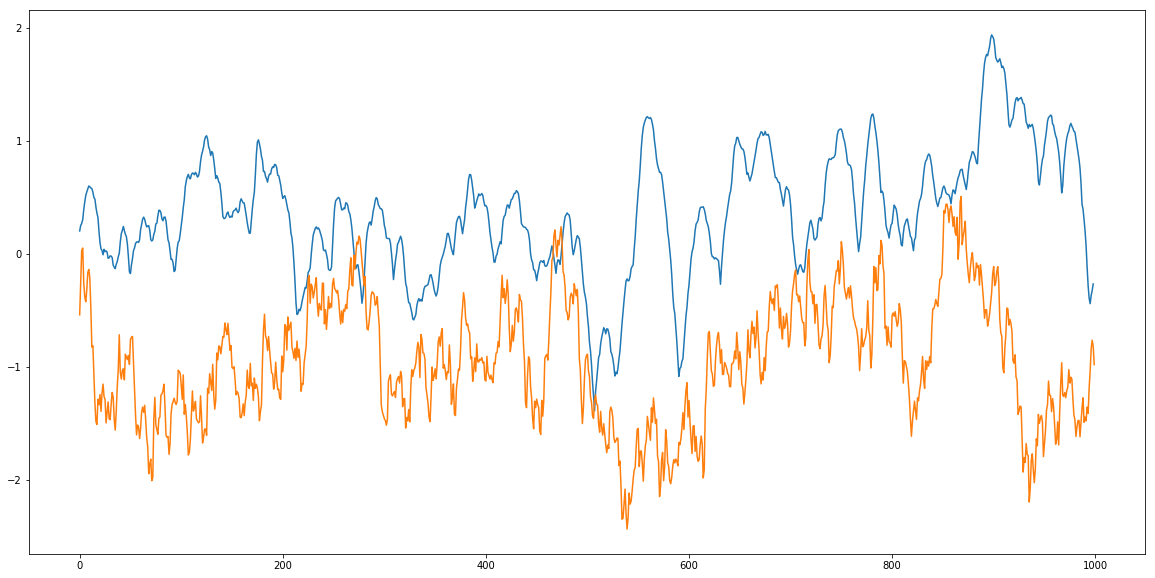

In [30]:
plt.figure(figsize=(20, 10)) 
plt.plot(range(0, T-1), beta)
plt.plot(range(0, T), truevol)
plt.show()

# HW 10 

In [31]:
# h_0は外からつける
def FFBS2(nsim, vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    amb = [0]*T
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    if m.ndim == 1:
        mb = np.random.normal(m.astype(np.float64), np.sqrt(C_float), size = nsim)
    else:
        mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
        
    m = m[0]
    amb[T-1] = mb
    
    for t in reversed(range(T-1)):
        
        if m.ndim == 1:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), 1/amR[t+1].astype(np.float64))
            
        else:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), np.linalg.inv(amR[t+1].astype(np.float64)))
            
        mH = amC[t]- np.dot(np.dot(mB, amR[t+1]), mB.T)
        
        if m.ndim == 1:
            mean = mm[t, :] + (mb - ma[t+1, :])*mB
            
        else:
            mean = mm[t, :] + np.dot((mb - ma[t+1, :]), mB.T)
            
        H_float = mH.astype(np.float64)
        
        if m.ndim == 1:
            mb = mean.astype(np.float64) + np.random.normal(0, np.sqrt(H_float[0][0]), size = nsim)
        else:
            mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(p), H_float, size = nsim)
        amb[t] = mb
    
    
    return amb

In [32]:
np.random.seed(123)
# prepare
vy = pd.read_csv("sv_simdata.csv").values[0][1:]
nT = vy.shape[0]
vy = np.array([np.log(i**2) for i in vy])
nsim = 500
nburn = 1000
dC0 = 2

# priors
## mu
dmm = 0
dCm = 1
## phi
dmp = 0.9
dCp = 0.1
## sigma
da0 = 0.1
db0 = 0.1

# mixture setup
nK = 10
vp_mix = [0.00609, 0.04775, 0.13057,0.20674,0.22715,0.18842,0.12047,0.05591,0.01575,0.00115]
vm_mix = [1.92677,1.34744,0.73504,0.02266,-0.85173,-1.97278,-3.46788,-5.55246,-8.68384,-14.65000]
vv2_mix = [0.11265,0.17788,0.26768,0.40611,0.62699,0.98583,1.57469,2.54498,4.16591,7.33342]

# initial values
dmu = dmm + np.sqrt(dCm) * np.random.normal()
while True:
    dphi = np.random.normal(loc = dmp, scale = np.sqrt(dCp))
    if abs(dphi) < 1:
        break
dsig2 = 1/np.random.gamma(da0, db0)
vs = np.random.choice(len(vp_mix), nT, p=vp_mix)

amG = np.zeros(nT)
amW = np.zeros(nT)
mF = np.ones((1, nT))
mh = np.zeros((nsim, nT + 1))
vphi = np.zeros(nsim)
vmu = np.zeros(nsim)
vsig2 = np.zeros(nsim)

In [ ]:
# MCMC
for i in range(nsim):
    
    # FFBS part
    vy_star = vy - dmu - np.array([vm_mix[j] for j in vs])
    vV = np.array([vv2_mix[j] for j in vs])
    amG[:] = dphi
    amW[:] = dsig2
    vh_star = FFBS2(1,vy_star,mF,vV,amG,amW,np.array([0]),dC0*dsig2)
    
    # posterior for h_0^star
    vhstar0 = np.random.normal(vh_star[0][0][0]*dphi*dC0/(dphi**2 * dC0 + 1), np.sqrt(dsig2 * dC0/(dphi**2 * dC0 + 1)))
    vh_star = [np.array([[vhstar0]])]+vh_star

    # sampling phi
    S1 = np.sum([vh_star[i][0][0]**2 for i in range(0, nT)])
    S2 = np.sum([vh_star[i][0][0]*vh_star[i-1][0][0] for i in range(1, nT+1)])
    alpha = S2/S1
    beta2 = dsig2/S1
    dmphi = (alpha * dCp + dmp * beta2)/(beta2 + dCp)
    dCphi = beta2*dCp/(beta2 + dCp)
    dphi = np.random.normal(loc = dmphi, scale = np.sqrt(dCphi))
    
    # sampling mu
    vh = [i + dmu for i in vh_star]
    S4 = np.sum([vh[i][0][0] - dphi*vh[i-1][0][0] for i in range(1, nT+1)])
    delta = (vh[0][0][0] + dC0*(1-dphi)*S4)/(1 + dC0*nT*(1-dphi)**2)
    eta2 = dsig2*dC0/(1 + dC0*nT*(1-dphi)**2)
    dmmu = (delta * dCm + dmm * eta2)/(dCm + eta2)
    dCmu = dCm * eta2 / (dCm + eta2)
    dmu = np.random.normal(loc = dmmu, scale = np.sqrt(dCmu))
    
    # sampling sigma
    S3 = np.sum([(vh_star[i][0][0] - dphi*vh_star[i-1][0][0])**2 for i in range(1, nT+1)])
    da = (nT + 1)/2 + da0
    db = 1/(db0 + S3/2)
    dsig2 = 1/np.random.gamma(shape = da, scale = db)
    
    # sampling latent
    for t in range(nT):
        vp = [vp_mix[k] * np.exp(-(vy_star[t] - vm_mix[k] - vh_star[t])**2/(2 * vv2_mix[k])) for k in range(nK)]
        newvp = [p[0][0]/sum(vp)[0][0] for p in vp]
        vs[t] = np.random.choice(len(newvp), 1, p=newvp)
        
    # store
    if i >= 0:
        vh = [i + dmu for i in vh_star]
        mh[i][:] = vh
        vphi[i] = dphi
        vmu[i] = dmu
        vsig2[i] = dsig2

In [ ]:
truephi = np.ones(nsim)*0.97
plt.figure(figsize=(20, 10))
plt.plot(truephi)
plt.plot(vphi)

In [ ]:
truemu = np.ones(nsim)*2*np.log(0.65)
plt.figure(figsize=(20, 10)) 
plt.plot(truemu)
plt.plot(vmu)
plt.show()

In [ ]:
truesig = np.ones(nsim)*0.15**2
plt.figure(figsize=(20, 10)) 
plt.plot(truesig)
plt.plot(vsig2)
plt.show()

In [ ]:
df = pd.read_csv("sv_truevol.csv")
truevol = df.values[0][1:]

result = np.zeros(nT)
for t in range(nT):
    result[t] = np.mean(mh[100:, t])

plt.figure(figsize=(20, 10)) 
plt.plot(result)
plt.plot(truevol)
plt.ylim(-2.5, 2.5)
plt.show()